[nbviewer](https://nbviewer.org/github/bom-Lee/GoingDeep_CV_DG/blob/main/%5BGD8%5DGO_STOP%21_Object_Detection.ipynb)

# 8. GO/STOP! - Object Detection 시스템 만들기
## 자율주행 보조장치
### (1) KITTI 데이터셋

**자율주행 보조장치 object detection 요구사항**

- 1) 사람이 카메라에 감지되면 정지
- 2) 차량이 일정 크기 이상으로 감지되면 정지


![img](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-4-P-passat_sensors.jpg)
http://www.cvlibs.net/datasets/kitti/


이번 시간에는 tensorflow_datasets에서 제공하는 KITTI 데이터셋을 사용해보겠습니다. KITTI 데이터셋은 자율주행을 위한 데이터셋으로 2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있습니다.

- [cvlibs에서 제공하는 KITTI 데이터셋](http://www.cvlibs.net/datasets/kitti/)

필요한 라이브러리를 불러 오겠습니다.
- KITTI 데이터셋을 다운로드

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

다운로드한 KITTI 데이터셋을 tfds.show_examples를 통해 보도록 합시다. 우리가 일반적으로 보는 사진보다 광각으로 촬영되어 다양한 각도의 물체를 확인할 수 있습니다.

In [ ]:
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"),"aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir = data_dir,
    split=['train','test'],
    shuffle_files=True,
    with_info=True,
)

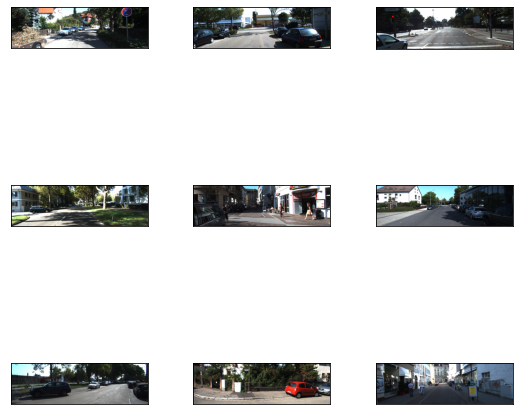

In [ ]:
_ = tfds.show_examples(ds_train, ds_info)

데이터 다운로드 시 담아둔 ds_info에서는 불러온 데이터셋의 정보를 확인할 수 있습니다.
오늘 사용할 데이터셋은
- 6,347개의 학습 데이터(training data)
- 711개의 평가용 데이터(test data)
- 423개의 검증용 데이터(validation data)로 구성되어 있습니다.
- 라벨에는 alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등의 정보가 있습니다.

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

### (2) 데이터 직접 확인하기
이번에는 데이터셋을 직접 확인하는 시간을 갖도록 하겠습니다. ds_train.take(1)을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 sample을 얻을 수 있습니다. 이렇게 뽑은 데이터에는 image 등의 정보가 포함되어 있습니다.

눈으로 확인해서 학습에 사용할 데이터를 직접 이해해 봅시다.

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-1.58,  2.08,  1.78, -1.51], dtype=float32)>, 'bbox': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.47138667, 0.47376007, 0.5426667 , 0.4955314 ],
       [0.26789334, 0.0534219 , 0.5182667 , 0.20785025],
       [0.45277333, 0.32633656, 0.54642665, 0.366562  ],
       [0.47277334, 0.43785828, 0.54112   , 0.45958132]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[1.65, 1.67, 3.64],
       [1.68, 1.67, 3.87],
       [1.87, 1.8 , 4.72],
       [1.61, 1.51, 4.5 ]], dtype=float32)>, 'location': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ -0.57,   1.59,  46.82],
       [ -9.09,   1.85,  14.99],
       [-10.22,   1.76,  41.23],
       [ -3.5 ,   1.6 ,  48.14]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 1, 0])>, 'rotation_y': <tf.Tensor: shape=(4,

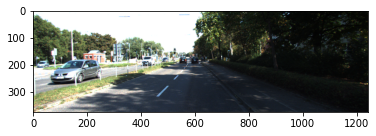

In [ ]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

이미지와 라벨을 얻는 방법을 알게 되었습니다. 그렇다면 이렇게 얻은 이미지의 바운딩 박스(bounding box, bbox)를 확인하기 위해서는 어떻게 해야 할까요?

아래는 KITTI에서 제공하는 데이터셋에 대한 설명입니다.

```python
데이터셋 이해를 위한 예시
Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
```

![img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-input.max-800x600.png)
[KITTI 원본이미지 예시]

![img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-sample.max-800x600.png)
[KITTI 이미지 바운딩 박스 시각화 예시]

위 설명과 예시 이미지를 참고하셔서 이미지 위에 바운딩 박스를 그려서 시각화해 보세요!

[Pillow 라이브러리의 ImageDraw 모듈](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html)을 참고하세요.

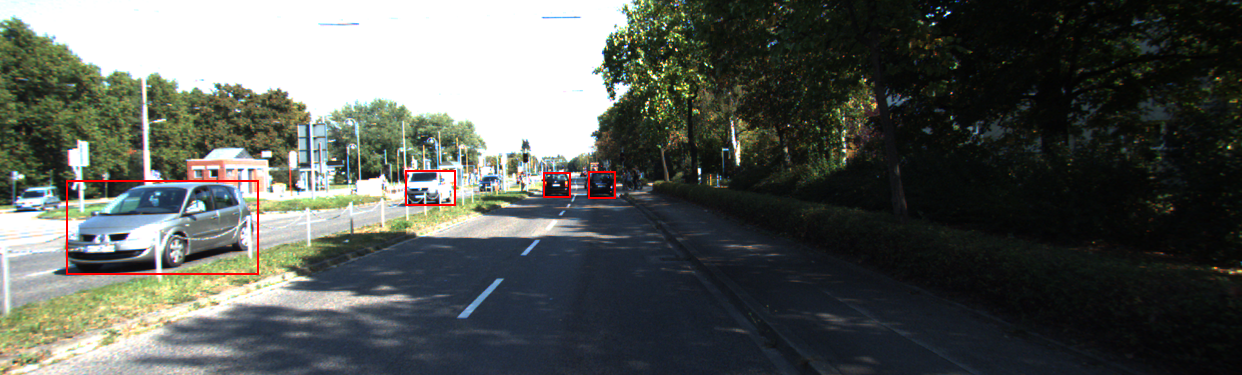

In [ ]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## RetinaNet

- [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)

RetinaNet은 **Focal Loss for Dense Object Detection** 논문을 통해 공개된 detection 모델입니다.

1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 있었습니다. 이를 해결하기 위해서 RetinaNet에서는 **focal loss**와 **FPN(Feature Pyramid Network)** 를 적용한 네트워크를 사용합니다.

### Focal Loss
> 물체를 배경보다 더 잘 학습하자 == 물체인 경우 Loss를 작게 만들자

![img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-car.max-800x600.png)
https://www.jeremyjordan.me/object-detection-one-stage/

Focal loss는 기존의 1-stage detection 모델들(YOLO, SSD)이 물체 전경과 배경을 담고 있는 모든 그리드(grid)에 대해 한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하고자 도입되었습니다. 여기서 그리드(grid)와 픽셀(pixel)이 혼란스러울 수 있겠는데, 위 그림 왼쪽 7x7 feature level에서는 한 픽셀이고, 오른쪽의 image level(자동차 사진)에서 보이는 그리드는 각 픽셀의 receptive field입니다.

그림에서 보이는 것처럼 우리가 사용하는 이미지는 물체보다는 많은 배경을 학습하게 됩니다. 논문에서는 이를 해결하기 위해서 Loss를 개선하여 정확도를 높였습니다.

![img](https://d3s0tskafalll9.cloudfront.net/media/original_images/focal_loss.png)
https://arxiv.org/abs/1708.02002


Focal loss는 우리가 많이 사용해왔던 교차 엔트로피를 기반으로 만들어졌습니다. 위 그림을 보면 Focal loss는 그저 교차 엔트로피 $CE(p_t)$의 앞단에 간단히 $(1-p_t)^\gamma$
라는 modulating factor를 붙여주었습니다.

교차 엔트로피의 개형을 보면 ground truth class에 대한 확률이 높으면 잘 분류된 것으로 판단되므로 손실이 줄어드는 것을 볼 수 있습니다. 하지만 확률이 1에 매우 가깝지 않은 이상 상당히 큰 손실로 이어지는데요.

이 상황은 물체 검출 모델을 학습시키는 과정에서 문제가 될 수 있습니다. 대부분의 이미지에서는 물체보다 배경이 많습니다. 따라서 이미지는 극단적으로 배경의 class가 많은 class imbalanced data라고 할 수 있습니다. 이렇게 너무 많은 배경 class에 압도되지 않도록 modulating factor로 손실을 조절해줍니다.$\gamma$를 0으로 설정하면 modulating factor $(1-p_t)^\gamma$
 가 1이 되어 일반적인 교차 엔트로피가 되고 $\gamma$가 커질수록 modulating이 강하게 적용되는 것을 확인할 수 있습니다.



### FPN(Feature Pyramid Network)
> 여러 층의 특성 맵(feature map)을 다 사용해보자

![img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-4-P-fpn.max-800x600.png)
https://arxiv.org/abs/1612.03144

FPN은 특성을 피라미드처럼 쌓아서 사용하는 방식입니다. CNN 백본 네트워크에서는 다양한 레이어의 결과값을 특성 맵(feature map)으로 사용할 수 있습니다. 이때 컨볼루션 연산은 커널을 통해 일정한 영역을 보고 몇 개의 숫자로 요약해 내기 때문에, 입력 이미지를 기준으로 생각하면 입력 이미지와 먼 모델의 뒷쪽의 특성 맵일수록 하나의 "셀(cell)"이 넓은 이미지 영역의 정보를 담고 있고, 입력 이미지와 가까운 앞쪽 레이어의 특성 맵일수록 좁은 범위의 정보를 담고 있습니다. 이를 **receptive field**라고 합니다. 레이어가 깊어질 수록 pooling을 거쳐 넓은 범위의 정보(receptive field)를 갖게 되는 것입니다.


FPN은 백본의 여러 레이어를 한꺼번에 쓰겠다라는데에 의의가 있습니다. SSD가 각 레이어의 특성 맵에서 다양한 크기에 대한 결과를 얻는 방식을 취했다면 RetinaNet에서는 receptive field가 넓은 뒷쪽의 특성 맵을 upsampling(확대)하여 앞단의 특성 맵과 더해서 사용했습니다. 레이어가 깊어질수록 feature map의 ww, hh방향의 receptive field가 넓어지는 것인데, 넓게 보는 것과 좁게 보는 것을 같이 쓰겠다는 목적인 거죠.

![img](https://d3s0tskafalll9.cloudfront.net/media/images/GC-3-P-FPN.max-800x600.png)
https://arxiv.org/abs/1708.02002

위 그림은 RetinaNet 논문에서 FPN 구조가 어떻게 적용되었는지를 설명하는 그림입니다. RetinaNet에서는 FPN을 통해 $P_3$ 까지의 pyramid level을 생성해 사용합니다. 각 pyramid level은 256개의 채널로 이루어지게 됩니다. 이를 통해 **Classification Subnet**과 **Box Regression Subnet** 2개의 Subnet을 구성하게 되는데, Anchor 갯수를 $A$라고 하면 최종적으로 Classification Subnet은 $K$개 class에 대해 $KA$개 채널을, Box Regression Subnet은 $4A$개 채널을 사용하게 됩니다.

## RetinaNet
### 데이터 포맷 변경
#### 클래스 및 바운딩 박스 정보 추출

In [ ]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df
        
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

  0%|          | 0/6347 [00:00<?, ?it/s]/tmp/ipykernel_1741/1178298058.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
100%|██████████| 6347/6347 [33:10<00:00,  3.19it/s]


테스트 데이터셋에 대해서도 동일하게 parse_dataset() 을 적용해 dataframe 생성

In [ ]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

  0%|          | 0/711 [00:00<?, ?it/s]/tmp/ipykernel_1741/1178298058.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
100%|██████████| 711/711 [03:56<00:00,  3.00it/s]


클래스 맵핑

In [ ]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
            
save_class_format(class_txt_path)

미리 설치해 둔 케라스 및 Keras RetinaNet 리포지토리 사용해 RetinaNet 훈련

In [ ]:
# RetinaNet 훈련이 시작됩니다!! 10epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

1 Physical GPUs, 1 Logical GPUs
Creating model, this may take a second...
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Model: "retinanet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________

학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환

In [ ]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
Done


### 시각화
#### 변환한 모델을 load, 추론 및 시각화

In [ ]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


#### 결과 확인을 위한 함수

In [ ]:
# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # reda
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()

[817.46564 151.18692 880.13385 179.5245 ]
[538.6162  167.97816 569.84094 192.19455]
[  0.       173.23872   57.620216 230.7338  ]


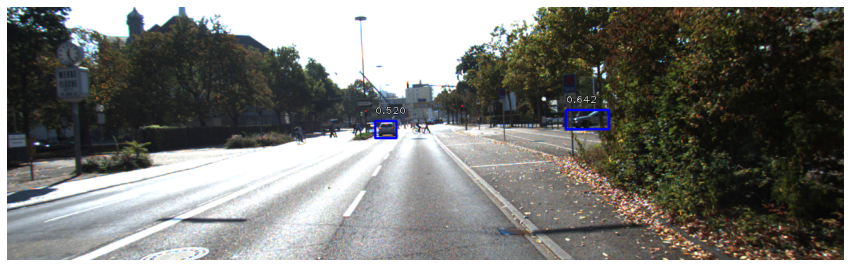

None


In [ ]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/go_3.png'
print(inference_on_image(model, img_path=img_path))

#### 다른 이미지에서 확인

[743.6202  161.3732  874.6894  216.55788]
[  0.      209.50208 309.44162 369.12827]
[ 995.4142   148.54546 1042.537    218.277  ]
[ 990.36804  151.9973  1021.8542   217.6777 ]


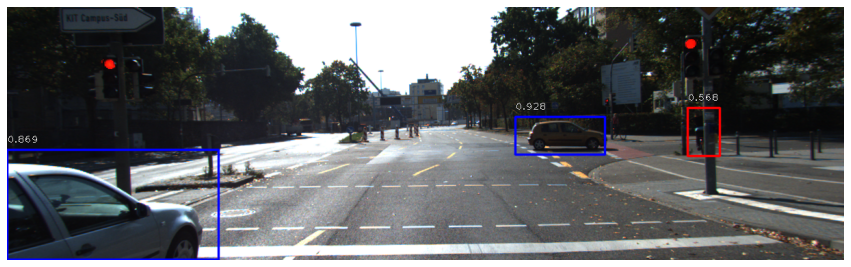

In [ ]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_3.png'
inference_on_image(model, img_path)

# 프로젝트: 자율주행 보조 시스템 만들기

In [ ]:
# 주요 라이브러리 버전 확인
import tensorflow as tf

print(tf.__version__)

2.8.0


### 데이터 준비

## 1. 자율주행 시스템 만들기
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

- 입력으로 이미지 경로를 받습니다.
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
- 조건은 다음과 같습니다.
  - 사람이 한 명 이상 있는 경우
  - 차량의 크기(width or height)가 300px이상인 경우

In [ ]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'

def self_drive_assist(model, img_path, size_limit=300, visualize=True):
    image = read_image_bgr(img_path)
    
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }
    
    #preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    #process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale
    
    # display images
    if visualize:
        result = 'Go'
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            w = b[2]-b[0]
            h = b[3]-b[1]
            
            if w >= size_limit or h >= size_limit or label == 1:
                result = 'Stop'
            else:
                result = 'Go'
                
            draw_box(draw, b, color=color_map[label])
            
            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)
        
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()
        
        return result

[410.67828 167.30537 499.62604 338.10147]
[432.73364 169.73546 487.9566  300.71243]


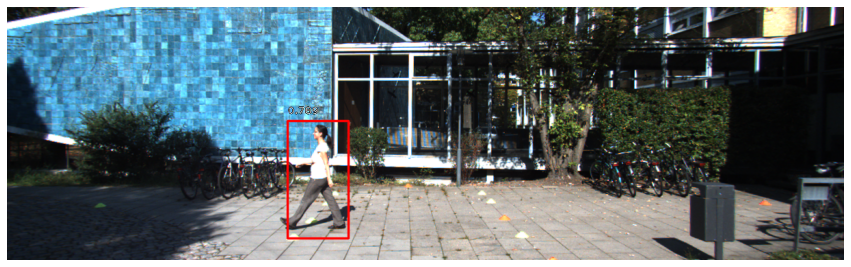

'Stop'

In [ ]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_2.png'
self_drive_assist(model=model, img_path=img_path)

## 2. 자율주행 시스템 평가하기
아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [ ]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("data/stop_1.png", "Stop"),
        ("data/stop_2.png", "Stop"),
        ("data/stop_3.png", "Stop"),
        ("data/stop_4.png", "Stop"),
        ("data/stop_5.png", "Stop"),
        ("data/go_1.png", "Go"),
        ("data/go_2.png", "Go"),
        ("data/go_3.png", "Go"),
        ("data/go_4.png", "Go"),
        ("data/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        print(image_path)
        pred = self_drive_assist(model=model, img_path=image_path, visualize=True)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

/aiffel/aiffel/object_detection/data/stop_1.png
[764.5733  146.47751 844.1831  317.78973]
[795.24927 149.84091 849.56055 294.38065]


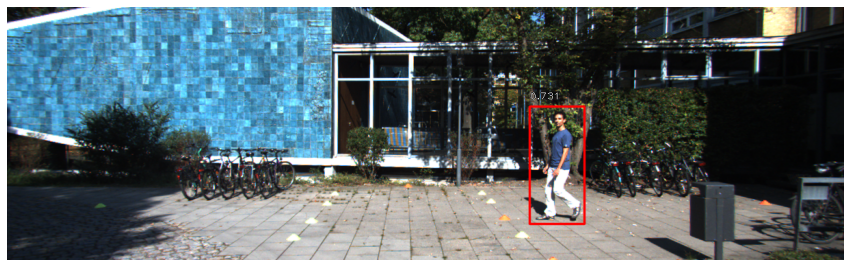

/aiffel/aiffel/object_detection/data/stop_2.png
[410.67828 167.30537 499.62604 338.10147]
[432.73364 169.73546 487.9566  300.71243]


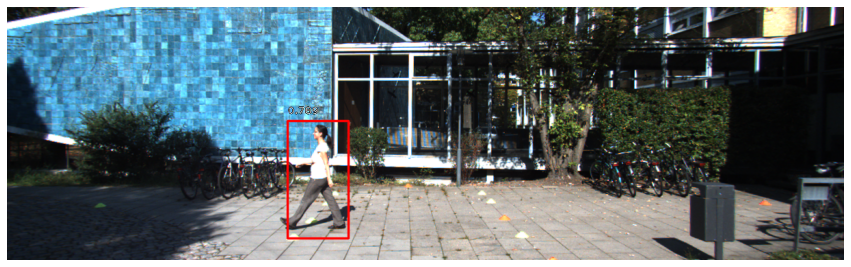

/aiffel/aiffel/object_detection/data/stop_3.png
[743.6202  161.3732  874.6894  216.55788]
[  0.      209.50208 309.44162 369.12827]
[ 995.4142   148.54546 1042.537    218.277  ]
[ 990.36804  151.9973  1021.8542   217.6777 ]


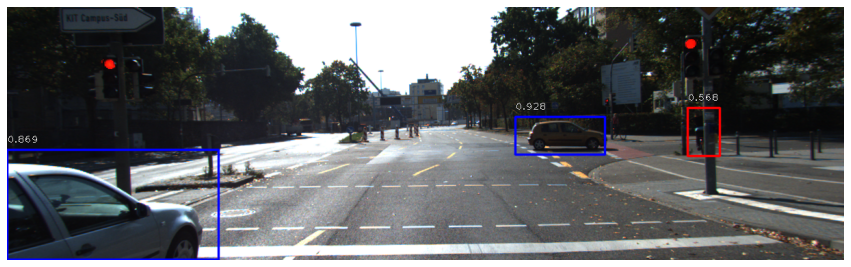

/aiffel/aiffel/object_detection/data/stop_4.png
[651.3973  143.50749 737.91473 229.29607]
[ 720.0907    86.13833 1105.1812   365.97037]
[436.31775 161.6185  551.8734  211.19148]
[350.90536 174.55765 469.67197 220.33478]
[ 46.759502 164.8193   375.4608   310.34537 ]
[381.4412  166.39238 529.50226 216.3024 ]
[663.9328  158.17783 778.1252  251.04417]
[693.5753  171.80635 816.9785  274.33585]


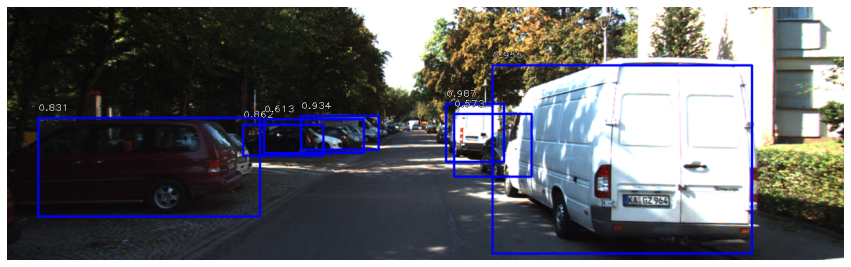

/aiffel/aiffel/object_detection/data/stop_5.png
[ 882.1761   180.49266 1241.0684   373.6249 ]
[695.34546 142.96858 779.0554  218.40546]
[733.7538  169.29399 860.0716  252.57584]
[561.5292  179.86298 619.58356 216.49377]
[703.61    154.26701 827.542   236.19145]
[690.9315  152.50534 750.19574 210.3665 ]


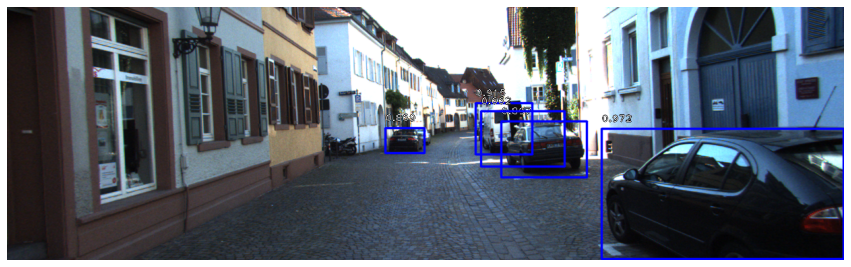

/aiffel/aiffel/object_detection/data/go_1.png
[590.43054 174.00078 626.39307 209.39755]
[187.31645 133.40808 357.65955 233.81566]
[528.38513 158.94247 565.0985  193.90407]
[374.34335 183.27823 417.6308  212.65651]
[440.55267 172.29697 472.74963 199.81738]


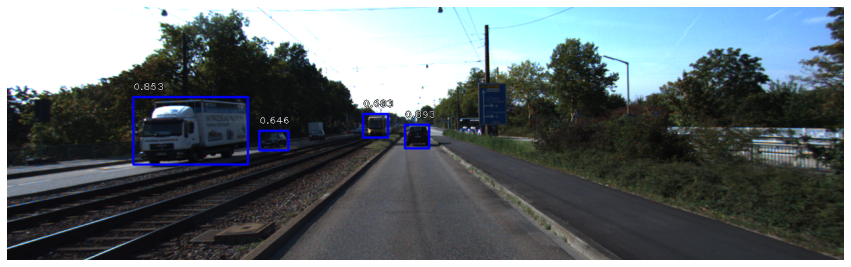

/aiffel/aiffel/object_detection/data/go_2.png
[510.22003 178.30598 569.85175 216.80452]
[623.5891  175.09523 670.17474 216.04099]
[529.4796  175.89539 580.7557  207.12253]


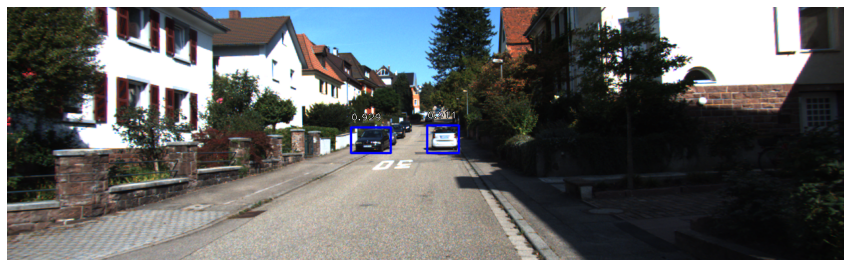

/aiffel/aiffel/object_detection/data/go_3.png
[817.46564 151.18692 880.13385 179.5245 ]
[538.6162  167.97816 569.84094 192.19455]
[  0.       173.23872   57.620216 230.7338  ]


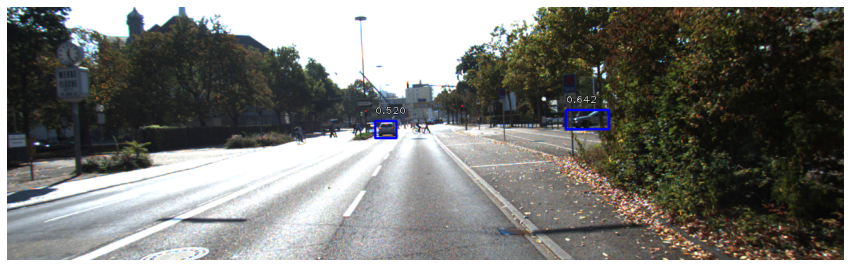

/aiffel/aiffel/object_detection/data/go_4.png
[689.0514  174.08418 794.13464 262.64114]
[683.7798  180.86684 760.6317  248.34212]


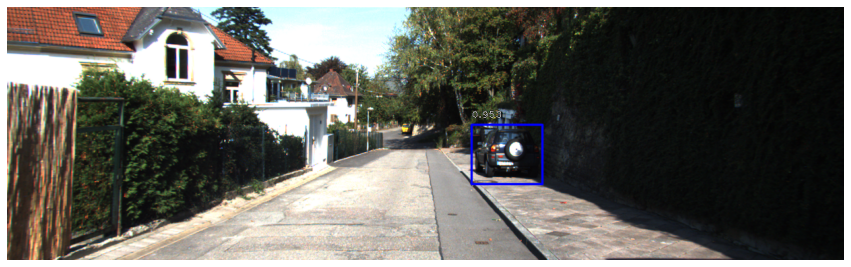

/aiffel/aiffel/object_detection/data/go_5.png
[  0.      187.28822 221.79056 307.93668]
[147.30305 183.80353 345.11847 258.4584 ]
[438.63687 179.75037 492.689   211.32918]
[320.7239  179.55936 431.4307  228.59682]
[ 892.9449   147.67314 1061.9762   200.94768]
[ 52.7195  187.32022 270.90176 273.54788]


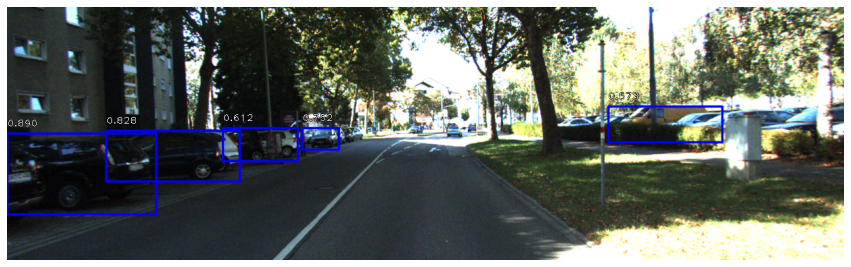

80점입니다.


In [ ]:
test_system(self_drive_assist)

## 루브릭
1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.
  - KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.

2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.
  - 바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.

3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.
  - 테스트 수행결과 90% 이상의 정확도를 보였다.

## 회고

이번 프로젝트는 지금까지 진행했던 프로젝트 중에서 가장 많은 에러를 볼 수 있었다.
(그것도 골고루..;;)

가장 처음 직면한 에러는 keras-retinanet이 설치가 잘못되었는지 거의 하루종일 설치 문제 해결한다고 붙들고 있었던 것 같다.

* ` Error : keras-retinanet error` 
    - 구글링으로 찾고 또 찾아서 해결.
    - 터미널에서 명령어들을 차례대로 실행시키니 에러 메세지가 사라졌다.
    - 버전 문제였는지 내가 경로를 잘못 설정해서 생긴 에러인지 구글링으로 하나씩 해보다 보니 에러 메세지가 사라짐.

```
!mkdir -p ~/aiffel/object_detection/data
!pip uninstall tensorflow
!pip install tensorflow==2.3.0
!cd ~/aiffel/object_detection
!git clone https://github.com/fizyr/keras-retinanet.git
!cd keras-retinanet && python setup.py build_ext --inplace
!pip install tensorflow_datasets tqdm
!pip install -r requirements.txt  # pip install -r requirements.txt [Errno 2] No such file or directory: 'requirements.txt'가 뜨긴 했지만 stackoverflow의 도움으로 해결.
!pip install .
```

- lms에서 돌아가는 부분이 있고 코랩에서 안돌아가는 부분이 있어서 (아마도 내 문제..)
경로 부분이 꼬여서 더 어려움을 겪은 것 같다.

* 코랩에서 '클래스 및 바운딩 박스 정보 추출' 하는 부분에서 생긴 에러는 `OSError: [Errno 5] Input/output error: '/content/drive/MyDrive/kitti/kitti_images/003678.png'` 였는데 이 부분이 해결이 안되서 작성하던 코드들을 들고 다시 lms 클라우드로 넘어갔다.

- 하나 해결하면 또 하나가 생기고 시간도 오래 걸리는데 진도가 안나가서 좀 힘든 프로젝트였다. 별거 아닌걸로 시간 잡아먹은 것 같아서 속상한.. 어쨋든 에러들을 해결하고 제출할 수 있어서 다행이다.


* 다양한 에러들..^^ㅎ
  - ` AlreadyExistsError: Another metric with the same name already exists.` 
  - ` typeerror: self_drive_assist() missing 1 required positional argument: 'img_path'` 